# Assignment 3

### Raymundo Gonzalez Leal

We want a tool that can tell us the maximum loan amount a given person can request while still having large opportunities of being approved. In order to achieve this, I will make a classifier that tells us whether a specific request (with a loan amount and other variables) would get approved or not, based on previous data. Finally, I will create a function that uses this classifier to greedily look for the largest loan amount that it can find and that results in an "approved" classification.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

## Data Prep

The first step was to decide which variables we could use. I manually deleted all the columns in the successful loan requests data set that did not appear in the rejected applications set (many of them was data regarding how the loan is being paid). Similarly, I removed the "Risk Score" and "policy code" columns from the rejected data set, as we don't have this variable in our successful loan applications. Including variables that are present in one of our sets and not the other would hinder our model, as the easiest way to make good predictions to wheter a loan is successful or not would be to check if there is some value for one of those variables (and hence this model would never learn the relationship between requested amount and chances of rejection).

After quick inspection, we see that most of the approved loans were completely funded (loan_amnt and funded_amnt are almost always the same). For simplicity, we will remove the funded_amnt variable, and assume that all approved loans were completely funded. I also removed information regarding the zip code and the date of the loan. Regarding date, I am using only the loans that were requested in the second quarter of 2017. The reason to use the most recent data, is so that inference is more valid for someone who requests a loan now (loan approval behavior by the company can change across time).

In [4]:
dataS = pd.read_csv('LoanStats_2017Q2.csv', sep=",")
dataS.columns = ["loan_amnt", "emp_length", "addr_state", "dti"]
dfS = pd.DataFrame(dataS)
dfS = dfS.drop(dfS.index[0])

#Get rid of instances without loan_amnt data
dfS = dfS.dropna(axis=0)

#Turning dti into a float
NewDti = []
for i in dfS['dti']:
    thisDti = float(i)
    NewDti.append(thisDti)
dfS['dti'] = NewDti


#Adding "approved" colum
dfS['approved'] = [1 for i in range(len(dfS['loan_amnt']))]



dfS.head()

,loan_amnt,emp_length,addr_state,dti,approved
1,8000,9 years,NJ,31.58,1
2,26000,7 years,DE,12.19,1
3,12000,3 years,CA,20.81,1
4,15000,1 year,TN,29.92,1
5,6000,2 years,TX,30.71,1


I manually modified the column order and names of the Rejected data set, so they match our Approved set.

In [ ]:
dataR = pd.read_csv('RejectStats_2017Q2.csv', sep=",", header=None)
dataR.columns = ["loan_amnt", "emp_length", "addr_state", "dti"]
dfR = pd.DataFrame(dataR)
dfR = dfR.drop(dfR.index[0])

#Get rid of instances without loan_amnt data
dfR = dfR.dropna(axis=0)

#Turning dti into a float
NewDti = []
for i in dfR['dti']:
    thisDti = float(i[:-1])
    NewDti.append(thisDti)
dfR['dti'] = NewDti

#Adding "approved" colum
dfR['approved'] = [0 for i in range(len(dfR['loan_amnt']))]

dfR.head()

In [13]:
## Make combined data frame.
df = pd.concat([dfS,dfR])


##Changing emp_length format
empt_length_dict = {'< 1 year': 0.5,
                    '1 year': 1,
                    '2 years': 2,
                    '3 years': 3,
                    '4 years': 4,
                    '5 years': 5,
                    '6 years': 6,
                    '7 years': 7,
                    '8 years': 8,
                    '9 years': 9,
                    '10 years': 10,
                    '10+ years': 15,
                    'n/a': None 
                   }



df["emp_length"].replace(empt_length_dict, inplace=True)
df.head()


,loan_amnt,emp_length,addr_state,dti,approved
1,8000,9.0,NJ,31.58,1
2,26000,7.0,DE,12.19,1
3,12000,3.0,CA,20.81,1
4,15000,1.0,TN,29.92,1
5,6000,2.0,TX,30.71,1


## Visualizing the Data

A good rule of thumb when we try to gain intuitions on relationships between data, is to plot it. We want to understand how the requested loan amount is related to the probabilities of getting the loan approved. Our objective is to see how high we can make our request while still having the loan approved. An implicit assumption here is that the higher the loan requested, the less likely it is to be approved. Let's see if this is an observable pattern.

Now we'll see a histogram of the approved loan amounts

In [25]:
success_loan_amnt = np.asarray(dfS['loan_amnt'])
success_loan_amnt =[float(numeric_string) for numeric_string in success_loan_amnt]

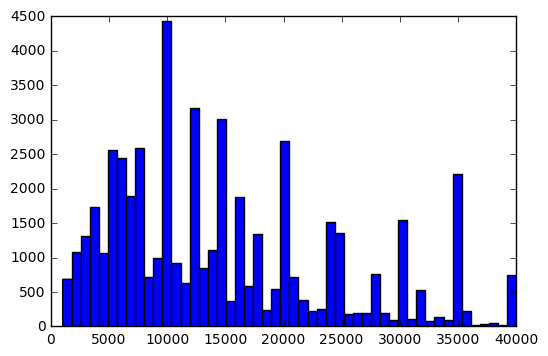

In [26]:
fig = plt.figure()
plt.hist(success_loan_amnt, bins=50)
plt.show()

Now we see the loan amounts for the unapproved data sets, and see if there is any clear difference between these and the approved loans

In [8]:
reject_loan_amnt = np.asarray(dfR['loan_amnt'])
reject_loan_amnt =[float(numeric_string) for numeric_string in reject_loan_amnt]

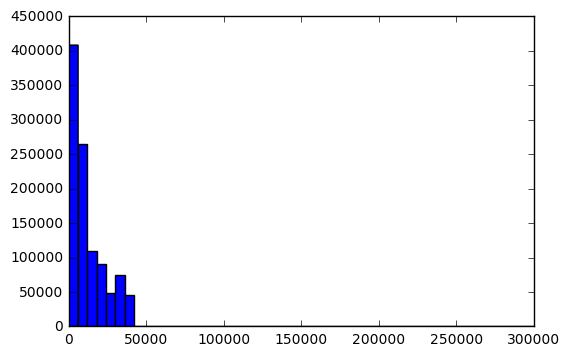

In [10]:
fig = plt.figure()
plt.hist(np.sort(reject_loan_amnt), bins=50)
plt.show()

In [32]:
print "rejected requests: ", len(reject_loan_amnt)
print "accepted requests: ", len(success_loan_amnt)

print "mean rejected loan amount: ",np.mean(reject_loan_amnt)
print "mean accepted loan amount: ",np.mean(success_loan_amnt)

rejected requests:  1048574
accepted requests:  50736
mean rejected loan amount:  12575.978116
mean accepted loan amount:  14810.5048683


The first thing to notice, is that the vast majority of our data is rejected applications, we have about 20 times as many rejected requests than accepted ones. Secondly, most of our rejected requests are in the same loan amount range as our accepted requests (less than 50,000). But we have some outliers who asked for much more. Some of them asked for 300,000. They were not many, and that is why they are not visible in the histogram (even though they enlarge the graph's domain). 

The most interesting thing is that the mean rejected loan amount is smaller than the mean accepted loan amount. Therefore, there may be a correlation with larger loans and getting your loan approved. This can be problematic if we want a model that tells us the maximum amount we can request, because it a model trained in this data may tell us that a larger requested loan has increased probabilities of being accepted! I will talk about this problem and potential solutions further on.

 ## Building the model

In [14]:
mapper = DataFrameMapper([
     (['loan_amnt'], sklearn.preprocessing.StandardScaler()),
     (['emp_length'], [sklearn.preprocessing.Imputer(), sklearn.preprocessing.StandardScaler()]),
     (['addr_state'], [sklearn.preprocessing.LabelBinarizer(),sklearn.preprocessing.StandardScaler()]),
     (['dti'], [sklearn.preprocessing.Imputer(),sklearn.preprocessing.StandardScaler()])   
     ])

np.round(mapper.fit_transform(df.copy()), 2)


## Train/Val split
y = df['approved']
y= y.as_matrix().astype(bool)
X = np.round(mapper.transform(df),2)
x_train, x_val, y_train, y_val = train_test_split(X,y, test_size=0.5, random_state = 4)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [33]:
## Using SMOTE to achieve class balance:

sm = SMOTE(random_state=5)
#We create balance on training data using SMOTE
x_train, y_train = sm.fit_sample(x_train, y_train)


In [43]:
clf1 = LogisticRegression(class_weight ='balanced')
clf2 = RandomForestClassifier(n_estimators = 500,class_weight= {True: 100, False:1})
clf3 = MLPClassifier(activation= 'relu', solver= 'lbfgs' , alpha=.01 , hidden_layer_sizes= (64,64)
                     ,learning_rate= 'adaptive' , max_iter=50 , learning_rate_init= 0.1) 

Voting = VotingClassifier(estimators = [('LR', clf1),('RF', clf2),  ('MLP', clf3) ], n_jobs=-1)

#Voting.fit(x_train, y_train)

clf3.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(64, 64), learning_rate='adaptive',
       learning_rate_init=0.1, max_iter=50, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

### Performance

In [45]:
y_hat = clf3.predict(x_val)
print metrics.classification_report(y_val,y_hat)

             precision    recall  f1-score   support

      False       0.99      0.83      0.90    524151
       True       0.19      0.84      0.31     25504

avg / total       0.95      0.83      0.88    549655



Our model has high precision for non approved requests (the "False" class) and quite low for the approved requests. We can say then that our model is "optimistic": Almost everything that it claims that won't be approved, didn't get approved, but many of the examples that were classified as approved didn't really make it. In practice, it may be better to have a "pessimistic" model, as we want to make sure that we at least get some money funded, and not take the risk of using a model that will tell us that we can safely request for more money when that is not the case. I experimented using SMOTE and class weights to fight class imbalance. This did improve results, but further work should be done to obtain a better model. In order to do this, we should do hyperparameter optimization for our models (using cross validation through a grid search or random search), and then we can build an ensemble classifier (I left above the code for a voting classifier, which can take a weighted vote, and the weights for this vote can also be optimized through a random or grid search).

## Using Classifier to predict maximum loan amount.

Ultimately, we want to be able to tell people what is the maximum amount of money they can ask for and still get approved for the loan (remember, we are assuming that approved loans will obtain all of their requested funding, which seems to be the case for most approved loans). 

This is the strategy that we will follow:

For a given instance (with all known predictors except for loan amount) we will assign a very low initial loan amount, the smallest that we have seen in our approved set. If the classifier predicts that the loan will not be  approved, we assume that the problem is not the amount but some other feature, and hence the person will get no loan approved. If the loan gets approved, we will start increasing loan amount, and see how much we can increase it while still having an approved loan.



In [47]:
def TryLoan(Instance,Clf,TryLoan = 3000):
    Instance[0]  = TryLoan
    InstanceD = {'loan_amnt': Instance[0], 'emp_length': Instance[1],
                 'addr_state': Instance[2], 'dti': Instance[3]}
    Instance = np.round(mapper.transform(pd.DataFrame(data = InstanceD, index=[1])),2)
    return Clf.predict(Instance)

    
testInstance = np.asarray([5000,3.0,'AZ',11.20]) 

print TryLoan(testInstance,clf3,7000)[0]
    

True


In [48]:
def MaxLoan(Instance, Clf, currLoan = 5000):
    Approved = True
    MaxLoan = currLoan
    while Approved:
        currLoan += 100
        Approved = TryLoan(Instance,Clf, TryLoan  = currLoan)[0]
        if Approved: MaxLoan = currLoan
        
    return MaxLoan
  
MaxLoan(testInstance,clf3)
    

47900

The instance in this example got an approved loan with a requested amount of 5000. Our Multilayered perceptron would still classify it as approved if the person had requested 47900. It makes sense that the boundary is so high, because as we saw most of our rejected loans had amounts very similar or lower to the rejected loans, except for some really high requested loans. I also tried a Random Forest, which gave a more intuitively reasonable result of 7000 dollars that could have been requested. However, that model also claimed that the person wouldn't have gotten the loan approved if they requested 8000, but approved if they requested 10,000. This extrange behaviour suggests that the Random Forest model (with the parameters we used) had high variance, and may be bad at generalizing. It seems like we will prefer simple models here, as they may show more interpretable rules, that are closer to our intuitions about reality, and may be more generalizable.

Our search approach makes intuitive sense, because we would expect that a larger loan will have less possibilities of approval all else being equal. Similarly, we would assume that requesting less money would never reduce the probabilities of getting the loan approved. There are two reasons why these assumptions may fail us here: The first one is that the assumptions may not be accurate in real life: maybe the company doesn't want to spend effort on small loans, and hence requesting less money could be hindering. The second reason is that even if in real life our assumptions are correct, our models may not reflect this accurately. Our models may be victim to sampling biases (especially if they have higher variance): Imagine that shorter employment length is correlated with smaller requested loans. Furthermore, short employment lengths may be a red flag that makes the person unlikely to receive a loan. In this scenario, there would be a correlation between small requested loan amounts and a reduced likelihood of being approved. Hence our model may tell us that a person should request a larger loan. 

The problem here, is that our model can not discern between correlations and causation, and we are asking a causal question. Maybe a way to correct this is using matching, so that the people in our "rejected" set are similar in all aspects to our group in the "accepted" set, except for the requested loan amounts.

## Training a model with Genetically matched Data

In [23]:
## First we save our combined data frame as a new csv
df = df.dropna(axis=0)
df.to_csv('CombinedData.csv')
#The csv file is generated with an unnecesary index column that I removed manually

I use the R package Matching to perform Genetic Matching. I will match our approved and non approved observations, achieving balance in all features except for loan amount. As a result, the only statistical difference between our approved and non approved groups will be the loan amount (although this could happen to be already balanced by chance), and this can help our model understand the causal link (that we assume exists) between loan amount and outcome (being approved or not). Here is a script I did to achieve feature balance on our two groups. Unfortunately, I was not able to succesfully run it. My computer froze every time I ran it, even if I used small population sizes and generations. This is probably due to the fact that the data set has more than 1 million rows, and my computer can't hold everything in memory.

In [ ]:
require('Matching')
require('rbounds')
require('foreign')

filename = 'CombinedData.csv'
dataset = read.csv(filename)

#Use seed for consistency
set.seed(415)

#Match (using "approved" as 'treatment', so that our classes are balanced )

#Variables we want to achieve balance on. 


X <- cbind(dataset$emp_length , dataset$dti ) 

#I do this to know later which are my matched units


genout <- GenMatch( Tr=dataset$approved, X=X,estimand="ATT", M=1,pop.size=50,
                   max.generations=10, wait.generations=10, replace = TRUE, ties = FALSE)
genmatch <- Match( Tr=dataset$approved, X=X, estimand="ATT", M=1, Weight.matrix=genout, replace = TRUE)


balance <- MatchBalance(dataset$approved ~ loan_amnt + emp_length,  data = dataset, match.out = genmatch, nboots=10)

matchedbase <- genmatch$mdata

#Make a new dataset only with those who survived matching

finaldata <- dataset[cbind(genmatch$index.treated , genmatch$index.control) ,]
finaldata = finaldata[,-c(1) ]


write.csv(finaldata, "MatchedData.csv")

